In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx

import sys, os
import datetime

import importlib
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
import st_toolkit as geohl
importlib.reload(geohl);

import cri_calc as cri
importlib.reload(cri);

import cri_helper as helper
importlib.reload(helper);

# Loading Dataset

In [4]:
df = pd.read_csv('./data/unipi_ais_dynamic_jul2018_1w_algn_linear_v2_w_lens.csv', parse_dates=['datetime'])
gdf = geohl.getGeoDataFrame_v2(df, crs='epsg:4326')

gdf2 = gdf.loc[gdf.datetime.dt.date.between(datetime.date(2018, 7, 3), datetime.date(2018, 7, 3), inclusive='both')].copy()
gdf_sub_moving = gdf2.loc[gdf2.speed.between(1, 50, inclusive='neither')].copy()

/home/andrewt/miniconda3/envs/vesai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [6]:
gdf_vcra = pd.read_pickle('./data/unipi_ais_dynamic_jul2018_1w_vcra_dataset_v3.pickle')

In [7]:
tqdm.pandas(desc='Adding Vessels\' Length...')

mlp_input = gdf_vcra.loc[gdf_vcra.own_Index.isin(gdf_sub_moving.index.values)].copy()
mlp_input.loc[:, 'own_length'] = mlp_input.own_Index.progress_apply(lambda l: gdf_sub_moving.loc[l].length)
mlp_input.loc[:, 'own_type'] = mlp_input.own_Index.progress_apply(lambda l: gdf_sub_moving.loc[l].type)
mlp_input.loc[:, 'target_type'] = mlp_input.target_Index.progress_apply(lambda l: gdf_sub_moving.loc[l].type)

Adding Vessels' Length...: 100%|██████████| 960268/960268 [01:44<00:00, 9213.71it/s]


# Getting Test Set

In [8]:
from sklearn.model_selection import train_test_split

X = mlp_input[['own_Index', 'own_type', 'dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'own_length']].values
y = mlp_input[['cri']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Loading Model

In [9]:
from joblib import dump, load

regr = load('./data/vcra-1w-mlp-hidden_256_32-with_own_length.model.joblib')
scaler = load('./data/vcra-1w-mlp-hidden_256_32-with_own_length.scaler.joblib')

In [15]:
mask_cargos = X_test[:, 1] == 'Container Ship'
mask_passenger = X_test[:, 1] == 'Ro-Ro/Passenger Ship'

X_test_cargos = X_test[mask_cargos]
X_test_passenger = X_test[mask_passenger]

In [18]:
cri_pred_cargos = pd.Series(regr.predict(scaler.transform(X_test_cargos[:, 2:])), name='Predicted CRI').clip(0, 1)
cri_pred_passenger = pd.Series(regr.predict(scaler.transform(X_test_passenger[:, 2:])), name='Predicted CRI').clip(0, 1)

In [19]:
collisions_cargos = pd.concat((gdf_sub_moving.loc[X_test_cargos[:, 0], ['mmsi', 'timestamp', 'geom', 'type']].reset_index(drop=True), cri_pred_cargos), axis=1)
collisions_cargos = gpd.GeoDataFrame(collisions_cargos, geometry='geom', crs='epsg:4326')
collisions_cargos.rename({0:'cri'}, axis=1, inplace=True)

In [20]:
collisions_passenger = pd.concat((gdf_sub_moving.loc[X_test_passenger[:, 0], ['mmsi', 'timestamp', 'geom', 'type']].reset_index(drop=True), cri_pred_passenger), axis=1)
collisions_passenger = gpd.GeoDataFrame(collisions_passenger, geometry='geom', crs='epsg:4326')
collisions_passenger.rename({0:'cri'}, axis=1, inplace=True)

In [23]:
%%time 

import osmnx as ox
from shapely.ops import transform
from functools import partial
import shapely as shp
import pyproj 

spatial_coverage_cargos = shp.geometry.box(*[*collisions_cargos.total_bounds])
spatial_coverage_passenger = shp.geometry.box(*[*collisions_passenger.total_bounds])

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3857')  # destination coordinate system
) 

# spatial_coverage_grid = create_area_grid(spatial_coverage, crs={'init':'epsg:4326'}, quadrat_width=0.01) # Angular
spatial_coverage_grid_cargos = geohl.create_area_grid(transform(project, spatial_coverage_cargos), crs={'init':'epsg:3857'}, quadrat_width=1500) # Meters
spatial_coverage_grid_passenger = geohl.create_area_grid(transform(project, spatial_coverage_passenger), crs={'init':'epsg:3857'}, quadrat_width=1500) # Meters

/home/andrewt/miniconda3/envs/vesai/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/andrewt/miniconda3/envs/vesai/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<timed exec>:35: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead t

CPU times: user 1.47 s, sys: 24.7 ms, total: 1.5 s
Wall time: 1.51 s


<timed exec>:35: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
<timed exec>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/andrewt/miniconda3/envs/vesai/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [24]:
plt_fontsize = 8


def get_heatmap(subplot_ax, spatial_area_heatmap, cmap_name='YlOrRd', vmin=None, vmax=None):
    style = "light_all"
#     cartodb_url_retina = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}@2x.png' % style
    
    west, south, east, north = spatial_area_heatmap.to_crs(epsg=3857).total_bounds
        
    subplot_ax.set_xlim(west, east)
    subplot_ax.set_ylim(south, north)

     
    spatial_area_heatmap.to_crs(epsg=3857).plot(column='no_of_pts', cmap=cmap_name, alpha=0.4, zorder=2, legend=False, ax=subplot_ax)

    sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=np.round(spatial_area_heatmap['no_of_pts'].min()) if vmin is None else vmin,
                                                                  vmax=np.round(spatial_area_heatmap['no_of_pts'].max()) if vmax is None else vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm, orientation='vertical', shrink=0.94, pad=0.02, ax=subplot_ax)

#     cax = plt.gcf().get_axes()[1]
    #and we can modify it, i.e.:
    cbar.ax.tick_params(labelsize=plt_fontsize)
    cbar.ax.set_ylabel(r'CRI', fontsize=plt_fontsize, labelpad=5)
    
#     cbar.ax.set_yticklabels([f'$10^{{\, {np.int64(label)} }}$' if label.is_integer() else '' for label in cbar.ax.get_yticks()])  # horizontal colorbar
    cbar.ax.tick_params(labelsize=plt_fontsize)
    cbar.ax.xaxis.set_ticks_position("bottom")

    subplot_ax.margins(0)
    subplot_ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    subplot_ax.grid(False)
    subplot_ax.ticklabel_format(useOffset=False, style='plain')
    
    return subplot_ax

Creating Spatial Index...
Classifying Spatial Proximity...
Gathering Results...


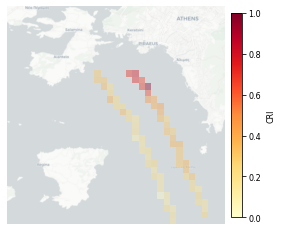

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
target_filename = f'vcra-containers-density-map.jpeg'


cluster_tp, trajectories_gdf, cmap_name = 'label', collisions_cargos, 'YlOrRd'

cargos_trajectories_gdf_classified = geohl.classify_area_proximity(trajectories_gdf.copy(), spatial_coverage_grid_cargos.to_crs(epsg=4326).copy(), 
                                                    o_id_column='mmsi', ts_column='timestamp')

spatial_coverage_grid_heatmap = spatial_coverage_grid_cargos.copy()



spatial_coverage_grid_heatmap['no_of_pts'] = cargos_trajectories_gdf_classified.groupby('area_id').apply(lambda l: l['Predicted CRI'].mean())    
get_heatmap(ax, spatial_coverage_grid_heatmap, cmap_name, 0, 1)    

ax.set_xlim(2.60e6, 2.65e6)
ax.set_ylim(4.53e6, 4.58e6)
    
ax.xaxis.set_tick_params(labelbottom=True, rotation=45)
ax.yaxis.set_tick_params(labelbottom=True)
fig.patch.set_visible(False)
ax.axis('off')
    
ctx.add_basemap(ax, attribution='', source=ctx.providers.CartoDB.Positron, zorder=0)


plt.savefig(os.path.join(target_filename), dpi=300, bbox_inches='tight')
plt.show()  

Creating Spatial Index...
Classifying Spatial Proximity...
Gathering Results...


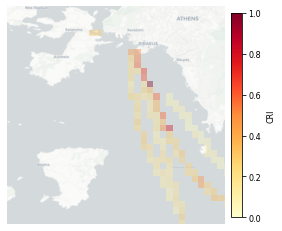

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
target_filename = f'vcra-passengers-density-map.jpeg'
    

cluster_tp, trajectories_gdf, cmap_name = 'label', collisions_passenger, 'YlOrRd'

passenger_trajectories_gdf_classified = geohl.classify_area_proximity(trajectories_gdf.copy(), spatial_coverage_grid_passenger.to_crs(epsg=4326).copy(), 
                                                    o_id_column='mmsi', ts_column='timestamp')

spatial_coverage_grid_heatmap = spatial_coverage_grid_passenger.copy()



spatial_coverage_grid_heatmap['no_of_pts'] = passenger_trajectories_gdf_classified.groupby('area_id').apply(lambda l: l['Predicted CRI'].mean())    
get_heatmap(ax, spatial_coverage_grid_heatmap, cmap_name, 0, 1)    

ax.set_xlim(2.60e6, 2.65e6)
ax.set_ylim(4.53e6, 4.58e6)
    
# ax.xaxis.set_tick_params(labelbottom=True, rotation=45)
# ax.yaxis.set_tick_params(labelbottom=True)
fig.patch.set_visible(False)
ax.axis('off')
    
ctx.add_basemap(ax, attribution='', source=ctx.providers.CartoDB.Positron, zorder=0)


plt.savefig(os.path.join(target_filename), dpi=300, bbox_inches='tight')
plt.show()  